<a href="https://colab.research.google.com/github/OVP2023/NLP/blob/main/NLP_DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 55.4 MB/s eta 0:00:00


In [4]:
responses = []
with bz2.BZ2File('/content/drive/MyDrive/Datasets/NLP/DZ1/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)



201030it [01:23, 2395.40it/s]


In [5]:
df=pd.DataFrame(responses)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [6]:
#1.1. Посчитайте количество отзывов в разных городах и на разные банки
df_city=df['city'].value_counts(dropna=False)
print(df_city)


city
г. Москва                                 55354
None                                      15174
г. Санкт-Петербург                        14342
г. Екатеринбург                            2337
г. Новосибирск                             2300
                                          ...  
г. Ленинск-кузнецкий                          1
г. Шемышейка                                  1
г. Саратов Саратовской области                1
г. Облучье (Еврейская автономная обл.)        1
г. Москва + Санкт-Петербург                   1
Name: count, Length: 5824, dtype: int64


In [7]:
df_bank=df['bank_name'].value_counts(dropna=False)
print(df_bank)

bank_name
Сбербанк России                  26327
Альфа-Банк                       10224
ВТБ 24                            8185
Русский Стандарт                  7943
Хоум Кредит Банк                  7549
                                 ...  
Фемили                               1
Современные Стандарты Бизнеса        1
Нэклис-Банк                          1
Жилстройбанк                         1
Юго-Восток                           1
Name: count, Length: 670, dtype: int64


In [8]:
list_text=df['text'].tolist()

In [9]:
#Средняя длина текстов в символах 1554, максимальное количество символов в тексте 32082, всего текстов 153499
len_data = df['text'].apply(len)
len_data.describe()

,text
count,153499.000000
mean,1554.212790
std,1319.098042
min,23.000000
25%,732.000000
50%,1193.000000
75%,1929.000000
max,32082.000000


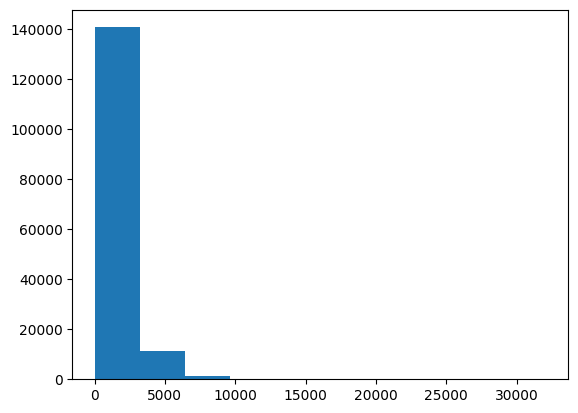

In [10]:
#1.2 Гистограмма длины текстов в символах
fig, ax = plt.subplots()
length = len_data.tolist()
n, bins, patches = ax.hist(length)
fig.show()

In [26]:
#Функция подсчета 10 наиболее встречающихся слов
from collections import Counter
from tqdm import tqdm_notebook as tqdm

def  word_count(col_name):
   cnt = Counter()
   n_types = []
   n_tokens = []
   tokens = []
   for index, row in tqdm(df.iterrows(), total = len(df)):
       tokens = row[col_name].split()
       cnt.update(tokens)
       n_types.append(len(cnt))
       n_tokens.append(sum(cnt.values()))
   for i in cnt.most_common(10):
       print(i)

#Функция удаления стоп слов из текста
from nltk.corpus import stopwords

nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['на', 'что', '-', 'и',  'я', 'по','Я','Вы']

def  remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

#Функция лемматизации текста
import pymorphy3

m = pymorphy3.MorphAnalyzer()

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()
    except:
        return " "

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#1.3 Найдем самые частые слова не меняя оригинальный текст
word_count('text')

<ipython-input-20-90f42a655ede>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('в', 1157262)
('и', 965735)
('не', 808409)
('на', 632541)
('что', 586864)
('я', 427944)
('с', 423586)
('по', 333342)
('-', 294086)
('мне', 277035)


In [21]:
#Найдем самые частые слова без стоп-слов
df['stopwords']= df.text.apply(remove_stopwords)
word_count('stopwords')

<ipython-input-20-90f42a655ede>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('В', 150939)
('это', 149096)
('банка', 142787)
('банк', 108339)
('деньги', 88936)
('И', 70944)
('карты', 63335)
('карту', 63213)
('На', 62779)
('очень', 51299)


In [27]:
#Найдем самые частые леммы после исключения стоп слов
df['lemma'] = df.stopwords.apply(lemmatize)
word_count('lemma')

<ipython-input-26-645d1ecb3d1c>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('банк', 395662)
('карта', 219718)
('это', 187914)
('мой', 171085)
('в', 154254)
('который', 142638)
('деньга', 128634)
('отделение', 109285)
('сотрудник', 109248)
('свой', 100649)


In [31]:
df.head(5)



,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,stopwords,lemma
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Добрый день! являюсь клиентом банка поручителе...,добрый день! являться клиент банк поручитель к...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Доброго дня! Являюсь держателем зарплатной кар...,добрый дня! являться держатель зарплатный карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Здравствуйте! Дублирую свое заявление 03.06.20...,здравствуйте! дублировать свой заявление 03.06...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"Добрый день!! открыл расчетный счет СберБанке,...",добрый день!! открыть расчётный счёт сбербанке...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"04.03.2015 г. взяла кредит вашем банке, заявле...","04.03.2015 г. взять кредит ваш банке, заявить ..."


ValueError: x and y must have same first dimension, but have shapes (0,) and (300,)

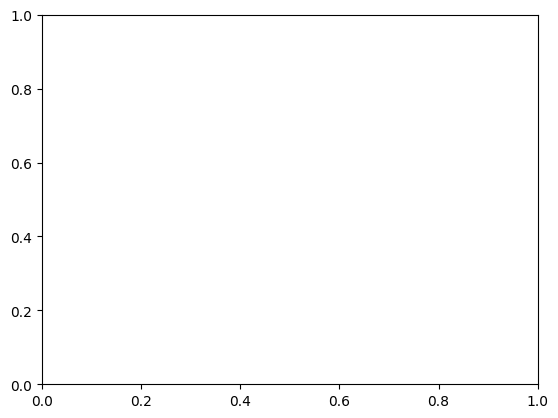

In [32]:
#1.4 Кривая Ципфа
cnt = Counter()
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()



NameError: name 'n_tokens' is not defined

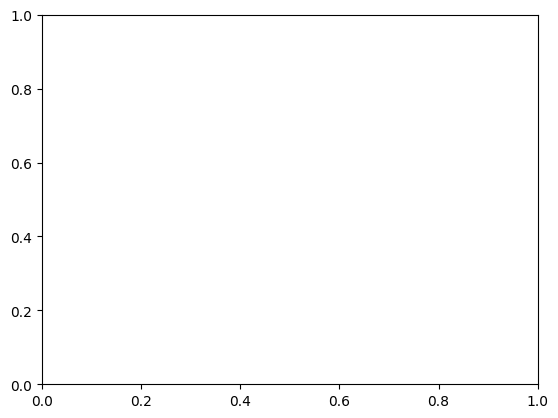

In [30]:
#Кривая Хипса
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

In [ ]:
'''Анализ текста
+1.1. Посчитайте количество отзывов в разных городах и на разные банки
+1.2. Постройте гистограмы длин слов в символах и в словах
1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных
1.4. Постройте кривые Ципфа и Хипса
1.5. Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и
"доверие"?
1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и
биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)
2. Тематическое моделирование
2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем
2.2. Приведите примеры понятных (интерпретируемых) тем
2.3. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать /объяснить'''

In [ ]:
'''Классификация текстов
Будем классифицировать на два класса, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)
3.1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой
5. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое
3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.
3.3. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием
символьных $n$-грам.
3.4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый
семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
3.5. Используйте accuracy и F-measure для оценки качества классификации.
Результат:
● Ноутбук с обученной моделью, где показаны результаты метрик качества: accuracy и f1-score
Инструменты:
● Ноутбук
● Подробное описание домашнего задания - здесь заменю ссылку на гитхаб'''